In [1]:
using Turing
using StatsPlots
using Optim

In [2]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")
include("lecture/plot_utils.jl");

### Dataset: World-Wide Monthly Air Passengers

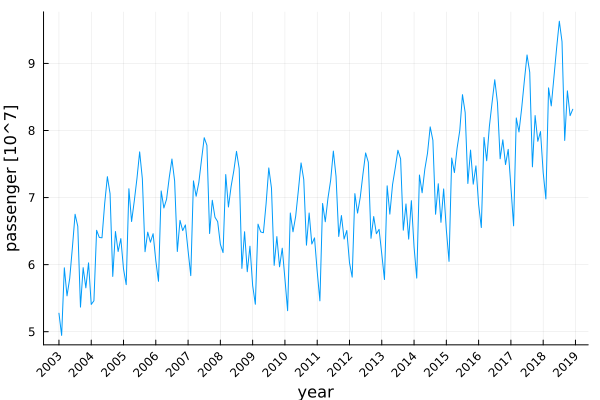

In [5]:
base_plot(air_passengers_2013_2018)

In [19]:
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"];

In [24]:
@model function trend_model(x::Vector{Float64}, y::Vector{Float64})
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    
    n_changepoints ~ DiscreteUniform(1,5)
    changepoints ~ filldist(Uniform(0, x[end] - x[1]), 5)
    adjustments ~ filldist( Normal(0,1), 5)
    
    for i in eachindex(y)
        t = x[i] - x[1]
        k = slope
        m = intercept
        
        for j in 1:n_changepoints
            changepoint = changepoints[j]
            adjustment = adjustments[j]
            
            if changepoint <= t
                k += adjustment
                m -= changepoint * adjustment
            end
        end
        
        y[i] ~ Normal(k * t + m, error+1e-5)
    end
end

trend_model (generic function with 2 methods)

In [26]:
Turing.Random.seed!(0)
res = sample(trend_model(x,y), MH(), 3000)
res

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×15×1 Array{Float64, 3}):

Iterations        = 1:1:3000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 2.66 seconds
Compute duration  = 2.66 seconds
parameters        = slope, intercept, error, n_changepoints, changepoints[1], changepoints[2], changepoints[3], changepoints[4], changepoints[5], adjustments[1], adjustments[2], adjustments[3], adjustments[4], adjustments[5]
internals         = lp

Summary Statistics
       parameters      mean       std      mcse   ess_bulk   ess_tail      rha ⋯
           Symbol   Float64   Float64   Float64    Float64    Float64   Float6 ⋯

            slope    0.1701    0.2173    0.0445    74.4219    13.5648    1.099 ⋯
        intercept    6.3383    0.7336    0.0775    39.4878    13.1168    1.099 ⋯
            error    0.8310    0.4730    0.1169    10.7618    10.0257    1.099 ⋯
   n_changepoints    3.8613    0.5362    0.1382    11.1931        NaN    1.091 ⋯
  changepoints[1]    9.4638    2.1370    0.4293    56

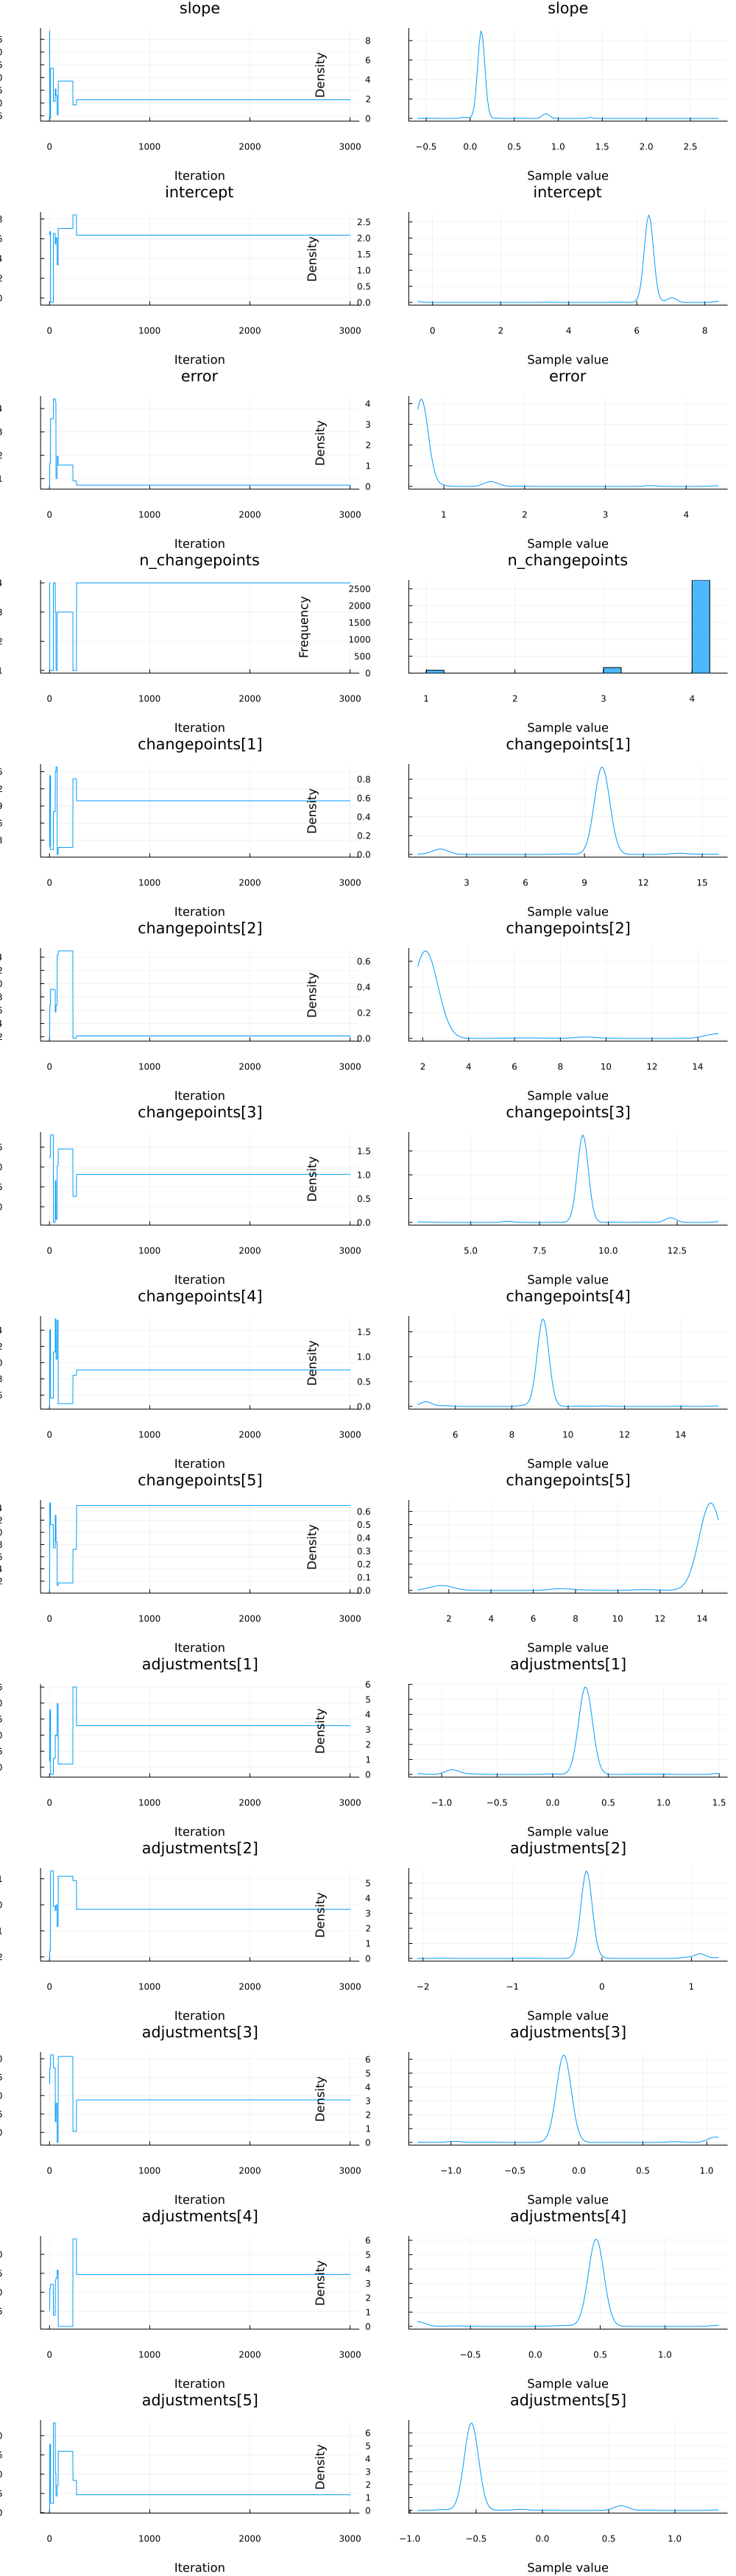

In [27]:
plot(res)

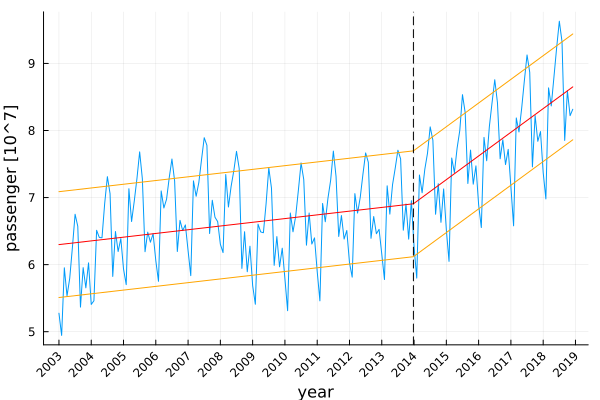

In [23]:
_, map_vector = get_map(res)
plot_trend_model_2(air_passengers_2013_2018, map_vector)